In [59]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
from IPython.display import Audio
import IPython.display as ipd
from scipy.io import wavfile
import tempfile
import os
import librosa
import pandas as pd
import seaborn as sns
import h5py
import mne
from scipy.stats import zscore
from mne_bids import BIDSPath, read_raw_bids
from matplotlib_venn import venn2,venn2_circles
from tqdm import tqdm

In [60]:
cm = 1/2.54
plt.rcParams['svg.fonttype'] = 'none'

fontdict = dict(fontsize=7)
fontsize = 7

red = '#A9373B'
blue = '#2369BD'
orange = '#CC8963'
green = '#009944'

stg_color = '#20B2AA'
smc_color = '#6A5ACD'
insula_color = '#D4AF37'

reds = sns.light_palette(red, as_cmap=True)
blues = sns.light_palette(blue, as_cmap=True)
oranges = sns.light_palette(orange, as_cmap=True)
greens = sns.light_palette(green, as_cmap=True)

recon_dir = '/cwork/ns458/ECoG_Recon/'
mne.viz.set_3d_backend('notebook')                    # MNE 3D in-notebook static backend
# text svg

'notebook'

# High-$\gamma$ Traces

## Phoeneme Sequencing

In [11]:
ref = 'bipolar'
task = 'PhonemeSequence'

hga_path = BIDSPath(
    root=f'../results/{task}({ref})',
    datatype='HGA',
    suffix='time',
    check=False,
)

HGAs = []
for path in tqdm(hga_path.match()):
    df = pd.read_csv(path)
    HGAs.append(df)
    
HGAs = pd.concat(HGAs, ignore_index=True)
HGAs = HGAs[HGAs['roi'].isin([
    'INS'
])]
HGAs.head()

100%|██████████| 90/90 [00:07<00:00, 12.18it/s]


,time,channel,value,mask,roi,hemi,subject,description,task,phase,label,x,y,z
5760,-1.000000,D0022_LPIF3-4,0.075033,False,INS,L,D0022,production,PhonemeSequence,NaN,ctx_lh_S_circular_insula_inf,-34.587586,-19.67704,-2.311079
5762,-0.992188,D0022_LPIF3-4,0.103754,False,INS,L,D0022,production,PhonemeSequence,NaN,ctx_lh_S_circular_insula_inf,-34.587586,-19.67704,-2.311079
5764,-0.984375,D0022_LPIF3-4,0.128319,False,INS,L,D0022,production,PhonemeSequence,NaN,ctx_lh_S_circular_insula_inf,-34.587586,-19.67704,-2.311079
5766,-0.976562,D0022_LPIF3-4,0.126154,False,INS,L,D0022,production,PhonemeSequence,NaN,ctx_lh_S_circular_insula_inf,-34.587586,-19.67704,-2.311079
5768,-0.968750,D0022_LPIF3-4,0.102751,False,INS,L,D0022,production,PhonemeSequence,NaN,ctx_lh_S_circular_insula_inf,-34.587586,-19.67704,-2.311079


In [5]:
# load stats
stats_path = BIDSPath(
    root=f'../results/{task}(roi)({ref})',
    datatype='HGA',
    suffix='roimask',
    check=False,
)
stats = []
for path in tqdm(stats_path.match()):
    df = pd.read_csv(path)
    stats.append(df)
    
stats = pd.concat(stats, ignore_index=True)
stats = stats[stats['roi'].isin([
    'INS'
])]
stats.head()


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 51.96it/s]


,time,mask,pval,roi,description,task
0,-1.000000,False,0.170366,INS,perception,PhonemeSequence
1,-0.992188,False,0.141972,INS,perception,PhonemeSequence
2,-0.984375,False,0.151370,INS,perception,PhonemeSequence
3,-0.976562,False,0.218556,INS,perception,PhonemeSequence
4,-0.968750,False,0.299540,INS,perception,PhonemeSequence


In [6]:
def sort_HGA(HGAs, hemi, description, roi):
    sub_df = HGAs[(HGAs.hemi == hemi) 
                  & (HGAs.description == description)
                  & (HGAs.roi == roi)].copy()

    # pivot 成 (channel, time) 矩阵
    hga_mat = sub_df.pivot(index='channel', columns='time', values='value')
    mask_mat = sub_df.pivot(index='channel', columns='time', values='mask')

    # 找每个 channel 第一个 significant 的时间点
    first_sig_time = []
    for ch in hga_mat.index:
        sig_times = mask_mat.loc[ch][mask_mat.loc[ch] == True].index
        if len(sig_times) > 0:
            first_sig_time.append(sig_times.min())
        else:
            first_sig_time.append(np.inf)  # 没有显著点的放最后

    # 按首次显著时间排序
    sort_idx = np.argsort(first_sig_time)
    hga_mat = hga_mat.iloc[sort_idx]
    mask_mat = mask_mat.iloc[sort_idx]

    # mask 掉 insignificant 的点
    hga_masked = np.where(mask_mat, hga_mat, np.nan)
    
    return hga_masked

/hpc/home/ns458/coganlab/nanlinshi/tmp/ipykernel_1499850/552335395.py:162: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=fontsize)
/hpc/home/ns458/coganlab/nanlinshi/tmp/ipykernel_1499850/552335395.py:162: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=fontsize)


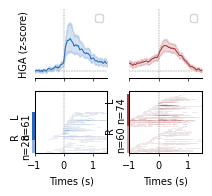

In [8]:
left_percetion = sort_HGA(HGAs, 'L', 'perception', 'INS')
right_percetion = sort_HGA(HGAs, 'R', 'perception', 'INS')
left_production = sort_HGA(HGAs, 'L', 'production', 'INS')
right_production = sort_HGA(HGAs, 'R', 'production', 'INS')

perception = np.concatenate([right_percetion, left_percetion])
production = np.concatenate([right_production, left_production])

n_perception,n_production = perception.shape[0], production.shape[0]

# to the same shape, pad with NaN to the end, not the beginning
perception = np.pad(
    perception,
    ((0, n_production - n_perception), (0, 0)),
    'constant',
    constant_values=np.nan
)

ax2_height = 0.01*(n_production + n_perception)
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=2, figsize=(5.5*cm, (ax2_height + 2.5)*cm),
                               gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [2.5, ax2_height]})


plt.subplots_adjust(wspace=0.3)

band_h, gap = 0.015, 0.01
order = ['INS']

sns.lineplot(
    data=HGAs[HGAs.description == 'perception'],
    x='time',
    y='value',
    hue='roi',
    hue_order=order,
    ax=ax1[0],
    palette=[blue],
    legend=False,
    lw=0.75
)

sns.lineplot(
    data=HGAs[HGAs.description == 'production'],
    x='time',
    y='value',
    hue='roi',
    hue_order=order,
    ax=ax1[1],
    palette=[red],
    legend=False,
    lw=.75
)

# ============ 画 significance bars 在 y<0 区域 ============
band_h = 0.06  # 每个 bar 的高度
gap = 0.06    # bar 之间的间隔
y_base = -0.45  # 从 y=-0.25 开始往上画
colors = {'INS': blue}  # perception 用 blue
colors_prod = {'INS': red}  # production 用 red

for ax_idx, (ax, desc, col_map) in enumerate([
    (ax1[0], 'perception', colors),
    (ax1[1], 'production', colors_prod)
]):
    for k, roi in enumerate(order):
        df_roi = stats[(stats['roi'] == roi) & (stats['description'] == desc)].sort_values('time')
        if df_roi.empty:
            continue
        
        sig = df_roi['mask'].astype(bool)
        runs = (sig != sig.shift()).cumsum()
        
        y_bottom = y_base + k * (band_h + gap)
        
        for _, g in df_roi.groupby(runs):
            if not g['mask'].iloc[0]:  # 只画 significant 的区间
                continue
            t0, t1 = g['time'].iloc[0], g['time'].iloc[-1]
            ax.fill_between(
                [t0, t1], 
                y_bottom, 
                y_bottom + band_h,
                color=col_map[roi], 
                alpha=1, 
                linewidth=0
            )

ax1[1].spines['left'].set_visible(False)
ax1[1].set_yticks([])

ax2[0].pcolormesh(HGAs.time.unique(),
               np.arange(perception.shape[0]), 
               perception,
               cmap=blues,
               rasterized=True
              )

ax2[1].pcolormesh(HGAs.time.unique(),
               np.arange(production.shape[0]), 
               production,
               cmap=reds,
               rasterized=True
              )

# ============ 左边加 bar 表示左右脑 ============
# perception
n_left_p = left_percetion.shape[0]
n_right_p = right_percetion.shape[0]
n_total_p = perception.shape[0]

# 画 bar（用 axvspan 或 bar）
bar_width = 0.08  # bar 宽度（相对于 x 轴范围）
x_left = -1 - bar_width  # bar 的 x 位置（在 heatmap 左边）

# 左脑 bar（下半部分）
ax2[0].barh(y=n_right_p + n_left_p/2, width=bar_width, height=n_left_p, 
            left=x_left, color=blue, edgecolor='none', clip_on=False)
# 右脑 bar（上半部分）
ax2[0].barh(y=n_right_p/2, width=bar_width, height=n_right_p, 
            left=x_left, color=blue, alpha=0.5, edgecolor='none', clip_on=False)

# 标注
ax2[0].text(x_left - 0.02, n_right_p + n_left_p/2, f'L\nn={n_left_p}', 
            ha='right', va='center', fontsize=fontsize, rotation=90)
ax2[0].text(x_left - 0.02, n_right_p/2, f'R\nn={n_right_p}', 
            ha='right', va='center', fontsize=fontsize, rotation=90)

# production
n_left_d = left_production.shape[0]
n_right_d = right_production.shape[0]
n_total_d = production.shape[0]

ax2[1].barh(y=n_right_d + n_left_d/2, width=bar_width, height=n_left_d, 
            left=x_left, color=red, edgecolor='none', clip_on=False)
ax2[1].barh(y=n_right_d/2, width=bar_width, height=n_right_d, 
            left=x_left, color=red, alpha=0.5, edgecolor='none', clip_on=False)

ax2[1].text(x_left - 0.02, n_right_d + n_left_d/2, f'L\nn={n_left_d}', 
            ha='right', va='center', fontsize=fontsize, rotation=90)
ax2[1].text(x_left - 0.02, n_right_d/2, f'R\nn={n_right_d}', 
            ha='right', va='center', fontsize=fontsize, rotation=90)


for ax in ax1:
    # remove the top, right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(labelsize=fontsize, width=0.5, length=2, which='both')
    plt.setp(ax.spines.values(), linewidth=0.75)
    
    ax.axvline(x=0, color='gray', linestyle='--', linewidth=0.35)
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.35)
    
    ax.set_ylim(-0.1, 0.8)
    ax.set_xlim(-1, 1.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_ylabel('HGA (z-score)', fontsize=fontsize)
    ax.set_xlabel('', fontsize=fontsize)

    ax.legend(fontsize=fontsize)
    
ax1[1].set_ylabel('')

for ax in ax2:
    # remove the top, right spines
    ax.tick_params(labelsize=fontsize, width=0.5, length=2, which='both')
    plt.setp(ax.spines.values(), linewidth=0.75)
    
    ax.set_xlim(-1, 1.5)
    ax.set_yticks([])
    
    ax.axvline(x=0, color='gray', linestyle='--', linewidth=0.35)
    ax.set_xlabel('Times (s)', fontsize=fontsize)

fig.savefig(f'../img/fig1/fig1_HGA_{task}_{ref}.svg', dpi=300, bbox_inches='tight')

## Lexical

In [9]:
ref = 'bipolar'
task = 'LexicalDelay'

hga_path = BIDSPath(
    root=f'../results/{task}({ref})',
    datatype='HGA',
    suffix='time',
    check=False,
)

HGAs = []
for path in tqdm(hga_path.match()):
    df = pd.read_csv(path)
    HGAs.append(df)
    
HGAs = pd.concat(HGAs, ignore_index=True)
HGAs = HGAs[HGAs['roi'].isin([
    'INS'
])]
HGAs.head()

100%|██████████| 320/320 [00:23<00:00, 13.52it/s]


,time,channel,value,mask,roi,hemi,subject,description,task,phase,label,x,y,z
3204,-1.000000,D0023_R2IF1-2,0.155462,False,INS,R,D0023,Repeat,LexicalDelay,Audio,ctx_rh_S_circular_insula_sup,33.08953,-8.19205,18.614382
3214,-0.992188,D0023_R2IF1-2,0.162128,False,INS,R,D0023,Repeat,LexicalDelay,Audio,ctx_rh_S_circular_insula_sup,33.08953,-8.19205,18.614382
3224,-0.984375,D0023_R2IF1-2,0.163627,False,INS,R,D0023,Repeat,LexicalDelay,Audio,ctx_rh_S_circular_insula_sup,33.08953,-8.19205,18.614382
3234,-0.976562,D0023_R2IF1-2,0.151027,False,INS,R,D0023,Repeat,LexicalDelay,Audio,ctx_rh_S_circular_insula_sup,33.08953,-8.19205,18.614382
3244,-0.968750,D0023_R2IF1-2,0.125289,False,INS,R,D0023,Repeat,LexicalDelay,Audio,ctx_rh_S_circular_insula_sup,33.08953,-8.19205,18.614382


In [10]:
HGAs = HGAs[HGAs.description == 'Decision']

In [11]:
HGAs.phase.unique()

array(['Go', 'Resp', 'Audio', 'Delay'], dtype=object)

In [12]:
def sort_HGA(HGAs, hemi, description, roi):
    sub_df = HGAs[(HGAs.hemi == hemi) 
                  & (HGAs.phase == description)
                  & (HGAs.roi == roi)].copy()

    # pivot 成 (channel, time) 矩阵
    hga_mat = sub_df.pivot(index='channel', columns='time', values='value')
    mask_mat = sub_df.pivot(index='channel', columns='time', values='mask')

    # 找每个 channel 第一个 significant 的时间点
    first_sig_time = []
    for ch in hga_mat.index:
        sig_times = mask_mat.loc[ch][mask_mat.loc[ch] == True].index
        if len(sig_times) > 0:
            first_sig_time.append(sig_times.min())
        else:
            first_sig_time.append(np.inf)  # 没有显著点的放最后

    # 按首次显著时间排序
    sort_idx = np.argsort(first_sig_time)
    hga_mat = hga_mat.iloc[sort_idx]
    mask_mat = mask_mat.iloc[sort_idx]

    # mask 掉 insignificant 的点
    hga_masked = np.where(mask_mat, hga_mat, np.nan)
    
    return hga_masked

/hpc/home/ns458/coganlab/nanlinshi/tmp/ipykernel_1499850/3194210179.py:162: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=fontsize)
/hpc/home/ns458/coganlab/nanlinshi/tmp/ipykernel_1499850/3194210179.py:162: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=fontsize)


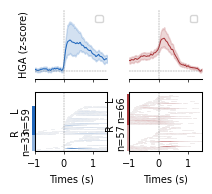

In [15]:
left_percetion = sort_HGA(HGAs, 'L', 'Audio', 'INS')
right_percetion = sort_HGA(HGAs, 'R', 'Audio', 'INS')
left_production = sort_HGA(HGAs, 'L', 'Resp', 'INS')
right_production = sort_HGA(HGAs, 'R', 'Resp', 'INS')

perception = np.concatenate([right_percetion, left_percetion])
production = np.concatenate([right_production, left_production])

n_perception,n_production = perception.shape[0], production.shape[0]

# to the same shape, pad with NaN to the end, not the beginning
perception = np.pad(
    perception,
    ((0, n_production - n_perception), (0, 0)),
    'constant',
    constant_values=np.nan
)

ax2_height = 0.01*(n_production + n_perception)
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=2, figsize=(5.5*cm, (ax2_height + 2.5)*cm),
                               gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [2.5, ax2_height]})


plt.subplots_adjust(wspace=0.3)

band_h, gap = 0.015, 0.01
order = ['INS']

sns.lineplot(
    data=HGAs[HGAs.phase == 'Audio'],
    x='time',
    y='value',
    hue='roi',
    hue_order=order,
    ax=ax1[0],
    palette=[blue],
    legend=False,
    lw=0.75
)

sns.lineplot(
    data=HGAs[HGAs.phase == 'Resp'],
    x='time',
    y='value',
    hue='roi',
    hue_order=order,
    ax=ax1[1],
    palette=[red],
    legend=False,
    lw=.75
)

# ============ 画 significance bars 在 y<0 区域 ============
# band_h = 0.06  # 每个 bar 的高度
# gap = 0.06    # bar 之间的间隔
# y_base = -0.45  # 从 y=-0.25 开始往上画
# colors = {'INS': blue}  # perception 用 blue
# colors_prod = {'INS': red}  # production 用 red

# for ax_idx, (ax, desc, col_map) in enumerate([
#     (ax1[0], 'perception', colors),
#     (ax1[1], 'production', colors_prod)
# ]):
#     for k, roi in enumerate(order):
#         df_roi = stats[(stats['roi'] == roi) & (stats['description'] == desc)].sort_values('time')
#         if df_roi.empty:
#             continue
        
#         sig = df_roi['mask'].astype(bool)
#         runs = (sig != sig.shift()).cumsum()
        
#         y_bottom = y_base + k * (band_h + gap)
        
#         for _, g in df_roi.groupby(runs):
#             if not g['mask'].iloc[0]:  # 只画 significant 的区间
#                 continue
#             t0, t1 = g['time'].iloc[0], g['time'].iloc[-1]
#             ax.fill_between(
#                 [t0, t1], 
#                 y_bottom, 
#                 y_bottom + band_h,
#                 color=col_map[roi], 
#                 alpha=1, 
#                 linewidth=0
#             )

ax1[1].spines['left'].set_visible(False)
ax1[1].set_yticks([])

ax2[0].pcolormesh(HGAs.time.unique(),
               np.arange(perception.shape[0]), 
               perception,
               cmap=blues,
               rasterized=True
              )

ax2[1].pcolormesh(HGAs.time.unique(),
               np.arange(production.shape[0]), 
               production,
               cmap=reds,
               rasterized=True
              )

# ============ 左边加 bar 表示左右脑 ============
# perception
n_left_p = left_percetion.shape[0]
n_right_p = right_percetion.shape[0]
n_total_p = perception.shape[0]

# 画 bar（用 axvspan 或 bar）
bar_width = 0.08  # bar 宽度（相对于 x 轴范围）
x_left = -1 - bar_width  # bar 的 x 位置（在 heatmap 左边）

# 左脑 bar（下半部分）
ax2[0].barh(y=n_right_p + n_left_p/2, width=bar_width, height=n_left_p, 
            left=x_left, color=blue, edgecolor='none', clip_on=False)
# 右脑 bar（上半部分）
ax2[0].barh(y=n_right_p/2, width=bar_width, height=n_right_p, 
            left=x_left, color=blue, alpha=0.5, edgecolor='none', clip_on=False)

# 标注
ax2[0].text(x_left - 0.02, n_right_p + n_left_p/2, f'L\nn={n_left_p}', 
            ha='right', va='center', fontsize=fontsize, rotation=90)
ax2[0].text(x_left - 0.02, n_right_p/2, f'R\nn={n_right_p}', 
            ha='right', va='center', fontsize=fontsize, rotation=90)

# production
n_left_d = left_production.shape[0]
n_right_d = right_production.shape[0]
n_total_d = production.shape[0]

ax2[1].barh(y=n_right_d + n_left_d/2, width=bar_width, height=n_left_d, 
            left=x_left, color=red, edgecolor='none', clip_on=False)
ax2[1].barh(y=n_right_d/2, width=bar_width, height=n_right_d, 
            left=x_left, color=red, alpha=0.5, edgecolor='none', clip_on=False)

ax2[1].text(x_left - 0.02, n_right_d + n_left_d/2, f'L\nn={n_left_d}', 
            ha='right', va='center', fontsize=fontsize, rotation=90)
ax2[1].text(x_left - 0.02, n_right_d/2, f'R\nn={n_right_d}', 
            ha='right', va='center', fontsize=fontsize, rotation=90)


for ax in ax1:
    # remove the top, right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(labelsize=fontsize, width=0.5, length=2, which='both')
    plt.setp(ax.spines.values(), linewidth=0.75)
    
    ax.axvline(x=0, color='gray', linestyle='--', linewidth=0.35)
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.35)
    
    ax.set_ylim(-0.1, 0.8)
    ax.set_xlim(-1, 1.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_ylabel('HGA (z-score)', fontsize=fontsize)
    ax.set_xlabel('', fontsize=fontsize)

    ax.legend(fontsize=fontsize)
    
ax1[1].set_ylabel('')

for ax in ax2:
    # remove the top, right spines
    ax.tick_params(labelsize=fontsize, width=0.5, length=2, which='both')
    plt.setp(ax.spines.values(), linewidth=0.75)
    
    ax.set_xlim(-1, 1.5)
    ax.set_yticks([])
    
    ax.axvline(x=0, color='gray', linestyle='--', linewidth=0.35)
    ax.set_xlabel('Times (s)', fontsize=fontsize)

fig.savefig(f'../img/fig1/fig1_HGA_{task}_{ref}.svg', dpi=300, bbox_inches='tight')

# Latency

In [88]:
import pandas as pd
import numpy as np
from mne_bids import BIDSPath
from tqdm import tqdm

task = ['PhonemeSequence', 'LexicalDelay']


ref = 'bipolar'
hga_paths = []
for t in task:
    hga_paths.extend(
        BIDSPath(
            root=f'../results/{t}({ref})',
            datatype='HGA',
            suffix='time',  # 注意这里改成 'time'
            check=False,
        ).match()
    )

# 2. 筛选 perception 和 passive 的数据
HGAs = []
for path in tqdm(hga_paths):
    df = pd.read_csv(path)
    # 只保留 perception 或 passive
    HGAs.append(df)

HGAs = pd.concat(HGAs)

# rename both phase : Resp and Response to Resp
HGAs.loc[HGAs.phase == 'Resp', 'phase'] = 'Response'
HGAs.loc[HGAs.phase == 'Response', 'phase'] = 'Response'

# rename phase of perception to audio
HGAs.loc[HGAs.description == 'passive', 'phase'] = 'Audio'
HGAs.loc[HGAs.description == 'perception', 'phase'] = 'perception'
HGAs.loc[HGAs.description == 'production', 'phase'] = 'production'

# rename INS to 'Insula'
HGAs.loc[HGAs.roi == 'INS', 'roi'] = 'Insula'
# combine HG to STG
HGAs.loc[HGAs.roi == 'HG', 'roi'] = 'STG'
# rename CG to Cingulate cortex
HGAs.loc[HGAs.roi == 'PrG', 'roi'] = 'SMC'
HGAs.loc[HGAs.roi == 'PoG', 'roi'] = 'SMC'
HGAs.loc[HGAs.roi == 'Subcentral', 'roi'] = 'SMC'

# HGAs = HGAs[HGAs.roi=='Insula']
HGAs.head()

100%|██████████| 500/500 [00:08<00:00, 59.91it/s]


,time,channel,value,mask,roi,hemi,subject,description,task,phase,label,x,y,z
0,-1.0,D0019_ROG3-4,-0.058845,False,OPC,R,D0019,perception,PhonemeSequence,perception,Unknown,17.039880,-94.822626,17.317047
1,-1.0,D0019_ROG13-14,-0.038425,False,mOccG,R,D0019,perception,PhonemeSequence,perception,ctx_rh_G_occipital_middle,41.472074,-88.150203,-3.545099
2,-1.0,D0019_ROG16-17,-0.037341,False,mOccG,R,D0019,perception,PhonemeSequence,perception,Unknown,38.211016,-84.512213,30.887423
3,-1.0,D0019_RLSO7-8,-0.044208,False,PhG,R,D0019,perception,PhonemeSequence,perception,ctx_rh_G_oc-temp_med-Parahip,18.457267,-10.274114,-31.949923
4,-1.0,D0019_ROG12-13,-0.040824,False,OccS,R,D0019,perception,PhonemeSequence,perception,ctx_rh_S_oc_sup_and_transversal,31.749467,-83.233475,16.079752


In [89]:
# rename insula roi to finer parcellation
# if  S_circular_insula_inf is in label, replace with Insula_circular_inf
HGAs.loc[HGAs.label.str.contains('S_circular_insula_inf'), 'roi'] = 'Insula_circular_inf'
# if  S_circular_insula_sup is in label, replace with Insula_circular_sup
HGAs.loc[HGAs.label.str.contains('S_circular_insula_sup'), 'roi'] = 'Insula_circular_sup'
# if  G_insular_short is in label, replace with Insula_short
HGAs.loc[HGAs.label.str.contains('S_circular_insula_ant'), 'roi'] = 'Insula_circular_ant'

HGAs.loc[HGAs.label.str.contains('G_insular_short'), 'roi'] = 'Insula_short'
HGAs.loc[HGAs.label.str.contains('G_Ins_lg_and_S_cent_ins'), 'roi'] = 'Insula_long'

In [90]:
def get_peak_latency(df):
    """Get peak latency in the significant regions"""
    results = []
    
    for (channel, desc), group in df.groupby(['channel', 'phase']):
        sig_data = group[group['mask'] == True]
        
        if len(sig_data) == 0:
            continue
            
        # 找到peak时间点
        peak_idx = sig_data['value'].idxmax()
        peak_row = sig_data.loc[peak_idx]
        
        results.append({
            'channel': channel,
            'description': desc,
            'peak_latency': peak_row['time'],
            'peak_value': peak_row['value'],
            'subject': peak_row['subject'],
            'task':peak_row['task'],
            'phase':peak_row['phase'],
            'roi': peak_row['roi'],
            'hemi': peak_row['hemi'],
            'label':peak_row['label'],
            'x': peak_row['x'],
            'y': peak_row['y'],
            'z': peak_row['z'],
        })
    
    return pd.DataFrame(results)

latency = get_peak_latency(HGAs)
latency = latency[latency.phase.isin(['Audio', 'perception','production','response'])]
latency.head()

,channel,description,peak_latency,peak_value,subject,task,phase,roi,hemi,label,x,y,z
0,D0019_RIIH5-6,production,-0.140625,0.208868,D0019,PhonemeSequence,production,OPC,R,ctx_rh_Pole_occipital,11.886836,-94.046488,10.403848
1,D0019_RLSO7-8,perception,0.242188,0.353339,D0019,PhonemeSequence,perception,PhG,R,ctx_rh_G_oc-temp_med-Parahip,18.457267,-10.274114,-31.949923
2,D0019_RLSO7-8,production,-0.242188,0.295257,D0019,PhonemeSequence,production,PhG,R,ctx_rh_G_oc-temp_med-Parahip,18.457267,-10.274114,-31.949923
3,D0019_RMOS3-4,production,-0.25,0.224136,D0019,PhonemeSequence,production,SPL,R,ctx_rh_G_parietal_sup,16.024804,-56.28823,68.934555
4,D0019_ROG10-11,production,-0.234375,0.242169,D0019,PhonemeSequence,production,sOccG,R,Unknown,27.552383,-88.739253,30.920567


In [91]:
import pandas as pd

def get_onset_latency(df):
    """
    Get ONSET latency (first significant time point) in the significant regions.
    Assumes 'mask' column indicates significant clusters.
    """
    results = []
    
    # 按 channel 和 phase 分组
    for (channel, phase), group in df.groupby(['channel', 'phase']):
        # 1. 只筛选显著的时间点
        sig_data = group[group['mask'] == True]
        
        if len(sig_data) == 0:
            continue
            
        # -------------------------------------------------------
        # 修改核心逻辑：不再找 idxmax (Peak)，而是找最早的时间点 (Onset)
        # -------------------------------------------------------
        
        # 2. 必须按时间排序，确保取到的是起始点
        # 假设你的时间列叫 'time'
        sig_data = sig_data.sort_values('time')
        
        # 3. 取第一行，这就是 Onset
        onset_row = sig_data.iloc[0]
        
        # 4. (可选) 鲁棒性检查：
        # 有时候 mask 可能是断断续续的（比如 [True, False, True, True...]）
        # 如果你想忽略那种非常短暂的偶然显著（比如只持续了10ms），
        # 你可以在这里加逻辑判断 consecutive points。
        # 但通常如果前面的置换检验做好了 cluster correction，直接取第一个点即可。

        results.append({
            'channel': channel,
            'description': onset_row['description'], # 确保列名存在
            'onset_latency': onset_row['time'],      # 这里改名为 onset_latency
            'peak_value': onset_row['value'],        # 记录一下 onset 时的强度，或者你可以保留 max value
            'subject': onset_row['subject'],
            'task': onset_row['task'],
            'phase': phase,
            'roi': onset_row['roi'],
            'hemi': onset_row['hemi'],
            'label': onset_row['label'],
            'x': onset_row['x'],
            'y': onset_row['y'],
            'z': onset_row['z'],
        })
    
    return pd.DataFrame(results)

# 使用新函数
latency = get_onset_latency(HGAs)

# 检查一下结果
latency.head()

,channel,description,onset_latency,peak_value,subject,task,phase,roi,hemi,label,x,y,z
0,D0019_RIIH5-6,production,-0.281250,0.114643,D0019,PhonemeSequence,production,OPC,R,ctx_rh_Pole_occipital,11.886836,-94.046488,10.403848
1,D0019_RLSO7-8,perception,-0.554688,0.116020,D0019,PhonemeSequence,perception,PhG,R,ctx_rh_G_oc-temp_med-Parahip,18.457267,-10.274114,-31.949923
2,D0019_RLSO7-8,production,-0.867188,0.152437,D0019,PhonemeSequence,production,PhG,R,ctx_rh_G_oc-temp_med-Parahip,18.457267,-10.274114,-31.949923
3,D0019_RMOS3-4,production,-0.304688,0.098594,D0019,PhonemeSequence,production,SPL,R,ctx_rh_G_parietal_sup,16.024804,-56.288230,68.934555
4,D0019_ROG10-11,production,-0.289062,0.121208,D0019,PhonemeSequence,production,sOccG,R,Unknown,27.552383,-88.739253,30.920567


In [92]:
import statsmodels.formula.api as smf

target_rois = ['STG','SMC', 'IFG',
            #    'Insula_circular_ant',
               'Insula_circular_sup',
               'Insula_circular_inf',
               'Insula_long',
               'Insula_short'] 

label = ['Audio', 'perception']
# label = ['Response', 'production']
df_model = latency[(latency['roi'].isin(target_rois)) & (latency.phase.isin(label))].copy()

df_model['onset_latency'] = pd.to_numeric(df_model['onset_latency'], errors='coerce')

model = smf.mixedlm("onset_latency ~ roi*hemi", data=df_model, groups=df_model["subject"])

result = model.fit(method=['nm', 'lbfgs'], maxiter=5000)

print(result.summary())

                     Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       onset_latency
No. Observations:         489           Method:                   REML         
No. Groups:               53            Scale:                    0.1032       
Min. group size:          1             Log-Likelihood:           -183.1001    
Max. group size:          34            Converged:                Yes          
Mean group size:          9.2                                                  
-------------------------------------------------------------------------------
                                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------
Intercept                             0.111    0.067  1.654 0.098 -0.021  0.243
roi[T.Insula_circular_inf]           -0.105    0.085 -1.225 0.221 -0.272  0.063
roi[T.Insula_circular_sup]           -0.076    0.083 -0.926 0

/hpc/home/ns458/coganlab/nanlinshi/tmp/ipykernel_2017156/3181458843.py:22: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  ax = sns.pointplot(data=df_model,
/hpc/home/ns458/coganlab/nanlinshi/tmp/ipykernel_2017156/3181458843.py:22: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  ax = sns.pointplot(data=df_model,


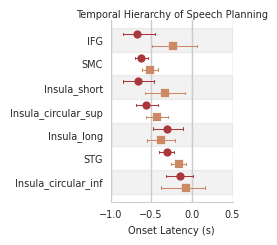

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 设定 ROI 顺序 (建议按照时间先后或者从前到后的解剖位置排序)
roi_order = [
            'IFG', 
            'SMC', 
            'Insula_short', 
            'Insula_circular_sup', 
            'Insula_long',
            'STG',
            'Insula_circular_inf', 
    ]

# 2. 设置画布风格
fig, ax = plt.subplots(figsize=(4*cm, 6*cm))

# 3. 画核心的点和误差棒 (Pointplot)
# join=False: 不要把点连成线，我们要的是独立的估计值
# dodge=0.5: 让左右脑的点错开，不要重叠
# errwidth & capsize: 调整误差棒的粗细和帽子，模仿参考图风格
ax = sns.pointplot(data=df_model, 
                   x="onset_latency", 
                   y="roi", 
                   hue="hemi",
                   order=roi_order,
                   palette={"L": red, "R": orange}, # 相同颜色
                   join=False,      # 关键：不连线
                   legend=False,
                   dodge=0.5,       # 关键：左右错开
                   markers=["o", "s"], # 左脑圆点，右脑方块，增加区分度
                   scale=0.8,       # 点的大小
                   errorbar=('ci', 95), # 显示 95% 置信区间 (或者用 'se' 显示标准误)
                   capsize=0.1,     # 误差棒的小帽子
                   errwidth=0.75)

# 4. 添加 0ms 参考线 (发声时刻)
# zorder=0 确保线在数据点后面
plt.axvline(0, color='black', linestyle='--', linewidth=0.75, alpha=0.5, zorder=0)

# 5. 添加背景条纹 (可选，像参考图那样的灰白相间)
# 这一步是为了模仿参考图的灰色背景带，增加可读性
for i in range(len(roi_order)):
    if i % 2 == 0: # 偶数行加灰色背景
        plt.axhspan(i - 0.5, i + 0.5, color='gray', alpha=0.1, zorder=0)

ax.set_xlim(-1, 0.5)
# 6. 美化调整
plt.xlabel("Onset Latency (s)", fontsize=7)
plt.ylabel("") # ROI 名字已经在 Y 轴刻度上了，不需要 Label
plt.title("Temporal Hierarchy of Speech Planning", fontsize=7, pad=2 )

# 调整图例

# 去掉上方和右侧边框
sns.despine(left=True)

# 调整 Y 轴刻度文字样式

for ax in fig.axes:
    ax.tick_params(labelsize=7, width=.75, length=2, which='both',)
    plt.setp(ax.spines.values(), linewidth=.75)
    
fig.savefig("insula_temporal.svg", dpi=300, bbox_inches='tight')

/hpc/home/ns458/coganlab/nanlinshi/tmp/ipykernel_2017156/315780310.py:25: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  ax = sns.pointplot(data=df_model_copy,
/hpc/home/ns458/coganlab/nanlinshi/tmp/ipykernel_2017156/315780310.py:25: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  ax = sns.pointplot(data=df_model_copy,


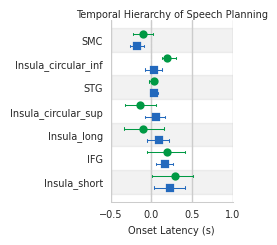

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 设定 ROI 顺序 (建议按照时间先后或者从前到后的解剖位置排序)
roi_order = [
    'SMC',                  # -0.367 (Anticipation/Prediction)
    'Insula_circular_inf',  # -0.105 (Early Sensory Integration)
    'STG',                  # -0.098 (Auditory Processing)
    'Insula_circular_sup',  # -0.076
    'Insula_long',          # -0.049
    'IFG',                  #  Baseline (Top-down Processing)
    'Insula_short'          # +0.061 (Latest)
]

# 2. 设置画布风格
fig, ax = plt.subplots(figsize=(4*cm, 6*cm))

# 3. 画核心的点和误差棒 (Pointplot)
# join=False: 不要把点连成线，我们要的是独立的估计值
# dodge=0.5: 让左右脑的点错开，不要重叠
# errwidth & capsize: 调整误差棒的粗细和帽子，模仿参考图风格
df_model_copy = df_model.copy()
df_model_copy.onset_latency = df_model_copy.onset_latency + 0.08

ax = sns.pointplot(data=df_model_copy, 
                   x="onset_latency", 
                   y="roi", 
                   hue="hemi",
                   order=roi_order,
                   palette={"L": blue, "R": green}, # 相同颜色
                   join=False,      # 关键：不连线
                   legend=False,
                   dodge=0.5,       # 关键：左右错开
                   markers=["o", "s"], # 左脑圆点，右脑方块，增加区分度
                   scale=0.8,       # 点的大小
                   errorbar=('ci', 95), # 显示 95% 置信区间 (或者用 'se' 显示标准误)
                   capsize=0.1,     # 误差棒的小帽子
                   errwidth=0.75)

# 4. 添加 0ms 参考线 (发声时刻)
# zorder=0 确保线在数据点后面
plt.axvline(0, color='black', linestyle='--', linewidth=0.75, alpha=0.5, zorder=0)

# 5. 添加背景条纹 (可选，像参考图那样的灰白相间)
# 这一步是为了模仿参考图的灰色背景带，增加可读性
for i in range(len(roi_order)):
    if i % 2 == 0: # 偶数行加灰色背景
        plt.axhspan(i - 0.5, i + 0.5, color='gray', alpha=0.1, zorder=0)

# 6. 美化调整
plt.xlabel("Onset Latency (s)", fontsize=7)
plt.ylabel("") # ROI 名字已经在 Y 轴刻度上了，不需要 Label
plt.title("Temporal Hierarchy of Speech Planning", fontsize=7, pad=2 )

# 调整图例
ax.set_xlim(-0.5, 1)
# 去掉上方和右侧边框
sns.despine(left=True)

# 调整 Y 轴刻度文字样式

for ax in fig.axes:
    ax.tick_params(labelsize=7, width=.75, length=2, which='both',)
    plt.setp(ax.spines.values(), linewidth=.75)
    
fig.savefig("insula_temporal.svg", dpi=300, bbox_inches='tight')

Reading labels from parcellation...
   read 75 labels from /cwork/ns458/ECoG_Recon/fsaverage/label/lh.aparc.a2009s.annot
   read 75 labels from /cwork/ns458/ECoG_Recon/fsaverage/label/rh.aparc.a2009s.annot


2025-12-23 20:06:40.565 (1341.632s) [    7F119A03B440]vtkXOpenGLRenderWindow.:1416  WARN| bad X server connection. DISPLAY=
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-23 20:06:40.632 (1341.699s) [    7F119A03B440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x163e19c0): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-23 20:06:40.851 (1341.918s) [    7F119A03B440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x9a3bcc0): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D e

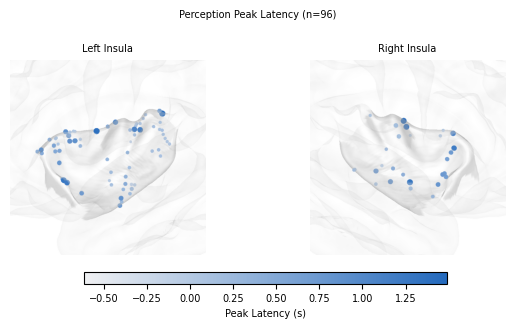

In [12]:
# 3D Insula Peak Latency Visualization - Perception
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from mne.viz import Brain
from scipy.spatial import cKDTree
import matplotlib.colors as mcolors

# 读取aparc.a2009s labels
labels = mne.read_labels_from_annot(
    subject='fsaverage', parc='aparc.a2009s',  
    hemi='both', subjects_dir=recon_dir
)

# Insula相关的labels (aparc.a2009s)
insula_patterns = ['G_insular_short', 'G_Ins_lg_and_S_cent_ins', 
                   'S_circular_insula_ant', 'S_circular_insula_inf', 'S_circular_insula_sup']

# 加载pial表面用于投影
lh_pial_coords, _ = mne.read_surface(f"{recon_dir}/fsaverage/surf/lh.pial")
rh_pial_coords, _ = mne.read_surface(f"{recon_dir}/fsaverage/surf/rh.pial")
lh_tree = cKDTree(lh_pial_coords)
rh_tree = cKDTree(rh_pial_coords)

# 计算insula区域的中心点
def get_insula_center(labels, hemi, pial_coords):
    vertices = []
    for lab in labels:
        if lab.hemi == hemi and any(p in lab.name for p in insula_patterns):
            vertices.extend(lab.vertices)
    if vertices:
        insula_coords = pial_coords[vertices]
        return insula_coords.mean(axis=0)
    return None

lh_insula_center = get_insula_center(labels, 'lh', lh_pial_coords)
rh_insula_center = get_insula_center(labels, 'rh', rh_pial_coords)

# 创建左右半球Brain对象
lh_brain = Brain(
    "fsaverage", subjects_dir=recon_dir, surf="pial",
    hemi="lh", background="white", show=False,
    cortex=(0.9, 0.9, 0.9), alpha=0.05, size=(800, 800)
)
rh_brain = Brain(
    "fsaverage", subjects_dir=recon_dir, surf="pial",
    hemi="rh", background="white", show=False,
    cortex=(0.9, 0.9, 0.9), alpha=0.05, size=(800, 800)
)

# 添加insula labels (高亮显示)
for lab in labels:
    if any(pattern in lab.name for pattern in insula_patterns):
        if lab.hemi == 'lh':
            lh_brain.add_label(lab, borders=False, color=(0.9, 0.9, 0.9), alpha=0.6)
        elif lab.hemi == 'rh':
            rh_brain.add_label(lab, borders=False, color=(0.9, 0.9, 0.9), alpha=0.6)

# Perception latency数据
perception_df = latency_df[latency_df['description'] == 'perception']
cord = perception_df[['x', 'y', 'z']].values
latency_values = perception_df['peak_latency'].values

mask_lh = cord[:, 0] < 0
mask_rh = cord[:, 0] > 0

# 设置 colormap 和归一化
cmap = blues
vmin, vmax = latency_values.min(), latency_values.max()
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# 点大小映射参数
size_min, size_max = 8, 25

def latency_to_size(lat, vmin, vmax, size_min, size_max):
    normalized = np.clip((lat - vmin) / (vmax - vmin), 0, 1)
    return size_min + normalized * (size_max - size_min)

def add_electrodes_with_latency(brain, coords, lat_vals, tree, pial_coords, cmap, norm, size_min, size_max):
    """添加电极，颜色和大小映射到latency"""
    _, indices = tree.query(coords)
    coords_proj = pial_coords[indices]
    
    for i in range(len(coords_proj)):
        pt = coords_proj[i:i+1]
        lat = lat_vals[i]
        color = cmap(norm(lat))[:3]
        size = latency_to_size(lat, vmin, vmax, size_min, size_max)
        
        cloud = pv.PolyData(pt)
        brain._renderer.plotter.add_mesh(
            cloud,
            render_points_as_spheres=True,
            point_size=size,
            color=color,
            lighting=False,
        )

# 添加左半球电极
if mask_lh.any():
    lh_cord = cord[mask_lh]
    lh_lat = latency_values[mask_lh]
    add_electrodes_with_latency(lh_brain, lh_cord, lh_lat, lh_tree, lh_pial_coords, 
                                cmap, norm, size_min, size_max)

# 添加右半球电极
if mask_rh.any():
    rh_cord = cord[mask_rh]
    rh_lat = latency_values[mask_rh]
    add_electrodes_with_latency(rh_brain, rh_cord, rh_lat, rh_tree, rh_pial_coords, 
                                cmap, norm, size_min, size_max)

# 设置视角 - 聚焦在insula中心
lh_brain.show_view(azimuth=180, elevation=90, distance=180, focalpoint=lh_insula_center)
rh_brain.show_view(azimuth=0, elevation=90, distance=180, focalpoint=rh_insula_center)

# 截图并显示
fig, axes = plt.subplots(1, 2, figsize=(16*cm, 8*cm))

axes[0].imshow(lh_brain.screenshot(mode="rgb"))
axes[0].axis("off")
axes[0].set_title("Left Insula", fontsize=fontsize)

axes[1].imshow(rh_brain.screenshot(mode="rgb"))
axes[1].axis("off")
axes[1].set_title("Right Insula", fontsize=fontsize)

# 添加colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, orientation='horizontal', fraction=0.05, pad=0.1, aspect=30)
cbar.set_label('Peak Latency (s)', fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)

plt.suptitle("Perception Peak Latency (n={})".format(len(perception_df)), fontsize=fontsize)

lh_brain.close()
rh_brain.close()

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-15 19:09:49.879 (  58.591s) [    7FB853687440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x17e1ec20): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-15 19:09:50.018 (  58.730s) [    7FB853687440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x17e1ec20): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: 

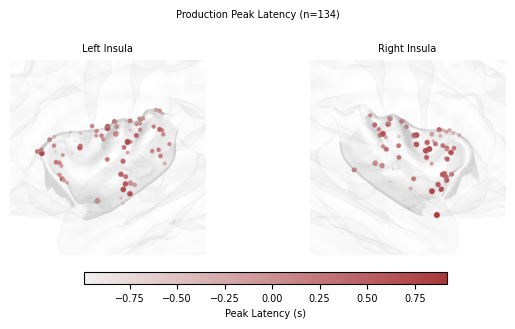

In [6]:
# 3D Insula Peak Latency Visualization - Production
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from mne.viz import Brain
from scipy.spatial import cKDTree
import matplotlib.colors as mcolors

# 创建左右半球Brain对象
lh_brain = Brain(
    "fsaverage", subjects_dir=recon_dir, surf="pial",
    hemi="lh", background="white", show=False,
    cortex=(0.9, 0.9, 0.9), alpha=0.05, size=(800, 800)
)
rh_brain = Brain(
    "fsaverage", subjects_dir=recon_dir, surf="pial",
    hemi="rh", background="white", show=False,
    cortex=(0.9, 0.9, 0.9), alpha=0.05, size=(800, 800)
)

# 添加insula labels (高亮显示)
for lab in labels:
    if any(pattern in lab.name for pattern in insula_patterns):
        if lab.hemi == 'lh':
            lh_brain.add_label(lab, borders=False, color=(0.9, 0.9, 0.9), alpha=0.6)
        elif lab.hemi == 'rh':
            rh_brain.add_label(lab, borders=False, color=(0.9, 0.9, 0.9), alpha=0.6)

# Production latency数据
production_df = latency_df[latency_df['description'] == 'production']
cord = production_df[['x', 'y', 'z']].values
latency_values = production_df['peak_latency'].values

mask_lh = cord[:, 0] < 0
mask_rh = cord[:, 0] > 0

# 设置 colormap 和归一化
cmap = reds
vmin, vmax = latency_values.min(), latency_values.max()
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# 添加左半球电极
if mask_lh.any():
    lh_cord = cord[mask_lh]
    lh_lat = latency_values[mask_lh]
    add_electrodes_with_latency(lh_brain, lh_cord, lh_lat, lh_tree, lh_pial_coords, 
                                cmap, norm, size_min, size_max)

# 添加右半球电极
if mask_rh.any():
    rh_cord = cord[mask_rh]
    rh_lat = latency_values[mask_rh]
    add_electrodes_with_latency(rh_brain, rh_cord, rh_lat, rh_tree, rh_pial_coords, 
                                cmap, norm, size_min, size_max)

# 设置视角 - 聚焦在insula中心
lh_brain.show_view(azimuth=180, elevation=90, distance=180, focalpoint=lh_insula_center)
rh_brain.show_view(azimuth=0, elevation=90, distance=180, focalpoint=rh_insula_center)

# 截图并显示
fig, axes = plt.subplots(1, 2, figsize=(16*cm, 8*cm))

axes[0].imshow(lh_brain.screenshot(mode="rgb"))
axes[0].axis("off")
axes[0].set_title("Left Insula", fontsize=fontsize)

axes[1].imshow(rh_brain.screenshot(mode="rgb"))
axes[1].axis("off")
axes[1].set_title("Right Insula", fontsize=fontsize)

# 添加colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, orientation='horizontal', fraction=0.05, pad=0.1, aspect=30)
cbar.set_label('Peak Latency (s)', fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)

plt.suptitle("Production Peak Latency (n={})".format(len(production_df)), fontsize=fontsize)

lh_brain.close()
rh_brain.close()

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

# Onset

In [90]:
# 计算每个电极的onset time (第一个significant时间点)
def get_onset_time(df):
    """对每个电极计算onset time，即第一个significant时间点"""
    results = []
    
    for (channel, desc), group in df.groupby(['channel', 'description']):
        sig_data = group[group['mask'] == True]
        
        if len(sig_data) == 0:
            continue
            
        # 找到第一个significant时间点
        onset_row = sig_data.loc[sig_data['time'].idxmin()]
        
        results.append({
            'channel': channel,
            'description': desc,
            'onset_time': onset_row['time'],
            'onset_value': onset_row['value'],
            'subject': onset_row['subject'],
            'roi': onset_row['roi'],
            'hemi': onset_row['hemi'],
            'x': onset_row['x'],
            'y': onset_row['y'],
            'z': onset_row['z'],
        })
    
    return pd.DataFrame(results)

onset_df = get_onset_time(HGAs)
onset_df.head(10)

,channel,description,onset_time,onset_value,subject,roi,hemi,x,y,z
0,D0022_LPIF3-4,production,-0.046875,0.097214,D0022,INS,L,-34.587586,-19.677040,-2.311079
1,D0028_LAI3-4,production,-1.000000,0.362469,D0028,INS,L,-34.543239,15.001830,0.344973
2,D0028_LPI1-2,production,0.546875,0.129383,D0028,INS,L,-38.438868,-7.224848,-9.879821
3,D0028_LPI3-4,production,0.734375,0.116121,D0028,INS,L,-39.538794,-6.389611,5.948131
4,D0035_LPI5-6,perception,0.265625,0.091263,D0035,INS,L,-37.145409,-10.812879,11.701601
5,D0035_LPI5-6,production,-0.687500,0.098342,D0035,INS,L,-37.145409,-10.812879,11.701601
6,D0035_LPI6-7,production,-0.984375,0.105992,D0035,INS,L,-37.202053,-10.164746,16.176046
7,D0040_L1IF2-3,perception,-0.054688,0.133943,D0040,INS,L,-24.755832,21.309497,8.575819
8,D0040_L1IF3-4,perception,-0.062500,0.101411,D0040,INS,L,-27.893969,22.003186,7.851646
9,D0040_L1SF1-2,perception,-0.046875,0.100191,D0040,INS,L,-22.788481,-15.003749,14.822504


VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-14 15:57:06.453 (6052.308s) [    7F3466DA7440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x99a8720): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-14 15:57:06.521 (6052.376s) [    7F3466DA7440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x99a8720): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: eg

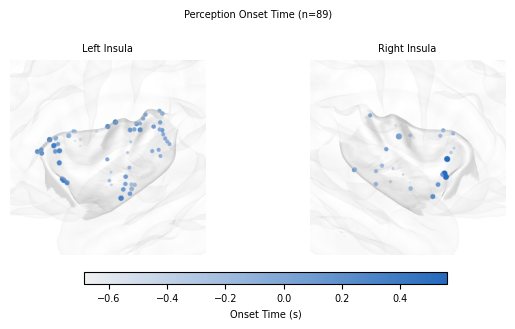

In [91]:
# 3D Insula Onset Time Visualization - Perception
# 创建左右半球Brain对象
lh_brain = Brain(
    "fsaverage", subjects_dir=recon_dir, surf="pial",
    hemi="lh", background="white", show=False,
    cortex=(0.9, 0.9, 0.9), alpha=0.05, size=(800, 800)
)
rh_brain = Brain(
    "fsaverage", subjects_dir=recon_dir, surf="pial",
    hemi="rh", background="white", show=False,
    cortex=(0.9, 0.9, 0.9), alpha=0.05, size=(800, 800)
)

# 添加insula labels (高亮显示)
for lab in labels:
    if any(pattern in lab.name for pattern in insula_patterns):
        if lab.hemi == 'lh':
            lh_brain.add_label(lab, borders=False, color=(0.9, 0.9, 0.9), alpha=0.6)
        elif lab.hemi == 'rh':
            rh_brain.add_label(lab, borders=False, color=(0.9, 0.9, 0.9), alpha=0.6)

# Perception onset数据
perception_onset = onset_df[onset_df['description'] == 'perception']
cord = perception_onset[['x', 'y', 'z']].values
onset_values = perception_onset['onset_time'].values

mask_lh = cord[:, 0] < 0
mask_rh = cord[:, 0] > 0

# 设置 colormap 和归一化
cmap = blues
vmin, vmax = onset_values.min(), onset_values.max()
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

def add_electrodes_with_onset(brain, coords, onset_vals, tree, pial_coords, cmap, norm, size_min, size_max):
    """添加电极，颜色和大小映射到onset time"""
    _, indices = tree.query(coords)
    coords_proj = pial_coords[indices]
    
    for i in range(len(coords_proj)):
        pt = coords_proj[i:i+1]
        onset = onset_vals[i]
        color = cmap(norm(onset))[:3]
        size = latency_to_size(onset, vmin, vmax, size_min, size_max)
        
        cloud = pv.PolyData(pt)
        brain._renderer.plotter.add_mesh(
            cloud,
            render_points_as_spheres=True,
            point_size=size,
            color=color,
            lighting=False,
        )

# 添加左半球电极
if mask_lh.any():
    lh_cord = cord[mask_lh]
    lh_onset = onset_values[mask_lh]
    add_electrodes_with_onset(lh_brain, lh_cord, lh_onset, lh_tree, lh_pial_coords, 
                              cmap, norm, size_min, size_max)

# 添加右半球电极
if mask_rh.any():
    rh_cord = cord[mask_rh]
    rh_onset = onset_values[mask_rh]
    add_electrodes_with_onset(rh_brain, rh_cord, rh_onset, rh_tree, rh_pial_coords, 
                              cmap, norm, size_min, size_max)

# 设置视角 - 聚焦在insula中心
lh_brain.show_view(azimuth=180, elevation=90, distance=180, focalpoint=lh_insula_center)
rh_brain.show_view(azimuth=0, elevation=90, distance=180, focalpoint=rh_insula_center)

# 截图并显示
fig, axes = plt.subplots(1, 2, figsize=(16*cm, 8*cm))

axes[0].imshow(lh_brain.screenshot(mode="rgb"))
axes[0].axis("off")
axes[0].set_title("Left Insula", fontsize=fontsize)

axes[1].imshow(rh_brain.screenshot(mode="rgb"))
axes[1].axis("off")
axes[1].set_title("Right Insula", fontsize=fontsize)

# 添加colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, orientation='horizontal', fraction=0.05, pad=0.1, aspect=30)
cbar.set_label('Onset Time (s)', fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)

plt.suptitle("Perception Onset Time (n={})".format(len(perception_onset)), fontsize=fontsize)

lh_brain.close()
rh_brain.close()

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-14 15:57:09.953 (6055.808s) [    7F3466DA7440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x148afb30): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-14 15:57:10.011 (6055.866s) [    7F3466DA7440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x148afb30): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: 

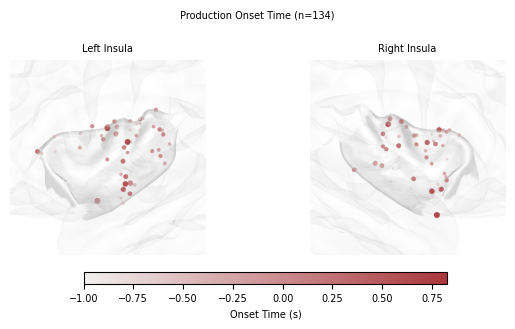

In [92]:
# 3D Insula Onset Time Visualization - Production
# 创建左右半球Brain对象
lh_brain = Brain(
    "fsaverage", subjects_dir=recon_dir, surf="pial",
    hemi="lh", background="white", show=False,
    cortex=(0.9, 0.9, 0.9), alpha=0.05, size=(800, 800)
)
rh_brain = Brain(
    "fsaverage", subjects_dir=recon_dir, surf="pial",
    hemi="rh", background="white", show=False,
    cortex=(0.9, 0.9, 0.9), alpha=0.05, size=(800, 800)
)

# 添加insula labels (高亮显示)
for lab in labels:
    if any(pattern in lab.name for pattern in insula_patterns):
        if lab.hemi == 'lh':
            lh_brain.add_label(lab, borders=False, color=(0.9, 0.9, 0.9), alpha=0.6)
        elif lab.hemi == 'rh':
            rh_brain.add_label(lab, borders=False, color=(0.9, 0.9, 0.9), alpha=0.6)

# Production onset数据
production_onset = onset_df[onset_df['description'] == 'production']
cord = production_onset[['x', 'y', 'z']].values
onset_values = production_onset['onset_time'].values

mask_lh = cord[:, 0] < 0
mask_rh = cord[:, 0] > 0

# 设置 colormap 和归一化
cmap = reds
vmin, vmax = onset_values.min(), onset_values.max()
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# 添加左半球电极
if mask_lh.any():
    lh_cord = cord[mask_lh]
    lh_onset = onset_values[mask_lh]
    add_electrodes_with_onset(lh_brain, lh_cord, lh_onset, lh_tree, lh_pial_coords, 
                              cmap, norm, size_min, size_max)

# 添加右半球电极
if mask_rh.any():
    rh_cord = cord[mask_rh]
    rh_onset = onset_values[mask_rh]
    add_electrodes_with_onset(rh_brain, rh_cord, rh_onset, rh_tree, rh_pial_coords, 
                              cmap, norm, size_min, size_max)

# 设置视角 - 聚焦在insula中心
lh_brain.show_view(azimuth=180, elevation=90, distance=180, focalpoint=lh_insula_center)
rh_brain.show_view(azimuth=0, elevation=90, distance=180, focalpoint=rh_insula_center)

# 截图并显示
fig, axes = plt.subplots(1, 2, figsize=(16*cm, 8*cm))

axes[0].imshow(lh_brain.screenshot(mode="rgb"))
axes[0].axis("off")
axes[0].set_title("Left Insula", fontsize=fontsize)

axes[1].imshow(rh_brain.screenshot(mode="rgb"))
axes[1].axis("off")
axes[1].set_title("Right Insula", fontsize=fontsize)

# 添加colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, orientation='horizontal', fraction=0.05, pad=0.1, aspect=30)
cbar.set_label('Onset Time (s)', fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)

plt.suptitle("Production Onset Time (n={})".format(len(production_onset)), fontsize=fontsize)

lh_brain.close()
rh_brain.close()

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

# TFR

In [7]:
from mne_bids import BIDSPath

# subject = 'D0040'
# pickchannels = ['D0040_L3ST1-2']

# subject = 'D0075'
# pickchannels = ['D0075_RAI6-7']

subject = 'D0096'
pickchannels = ['D0096_LTPS2-3']


task = 'PhonemeSequence'

bids_root = '/cwork/ns458/BIDS-1.4_Phoneme_sequencing/BIDS/'

description = 'production'

tfr_path = BIDSPath(
    root=os.path.join(bids_root, 'derivatives', 'tfr'),
    datatype='bipolar',
    suffix='tfr',
    extension='.h5',
    check=False
)

tfr_path = tfr_path.copy().update(subject=subject, description=description)
tfr = mne.time_frequency.read_tfrs(
    tfr_path.fpath,
    verbose=False
)

stats_path = tfr_path.copy().update(
            suffix='stats',
        )

stats = h5py.File(stats_path.fpath, 'r')
mask = stats['mask'][()]
pvals = stats['pvals'][()]
stats.close()

idx = tfr.ch_names.index(pickchannels[0])
tfr = tfr.pick(pickchannels)

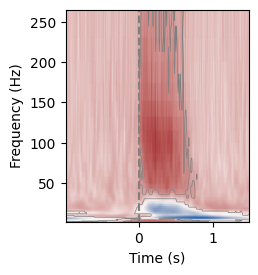

In [8]:
freqs = tfr.freqs
times = tfr.times

ch_data = tfr.get_data()[0]  # Take the first (and only) channel
p_threshold = 0.01
significant = (pvals[idx] < p_threshold) & (mask[idx] > 0)

fig, ax = plt.subplots(figsize=(6*cm, 7*cm))
im = ax.pcolormesh(
            times, freqs, ch_data, shading='gouraud',
            cmap='vlag', rasterized=True,
            vmin=ch_data.min(),
            vmax=ch_data.max(),
        )

if np.any(significant):
    # Create a binary mask for significant clusters
    sig_cluster = np.zeros_like(mask[idx])
    sig_cluster[significant] = 1

    # Plot the significant clusters
    ax.contour(times, freqs, sig_cluster,
            levels=[0.6], 
            colors='gray',
            linewidths=0.5,
            linestyles='-')
    
ax.axvline(x=0, color='gray', linestyle='--')    
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (Hz)')
plt.show()